# Ciencia de datos aplicada (ITBA): Modelo de tercer entregable

**Entrenamiento y validación de Modelos de Machine Learning**

**Equipo:** Desiree Melisa Limachi, Felipe Mendiondo, German Lorenzani

**Nombre del proyecto**: Sistema de pricing dinámico para ATUA



### 🧾 1. Importación y carga de librerías

In [ ]:
import pandas as pd

# Reemplazá con la ruta local si se descargo el archivo manualmente, ubicar ambos archivos en una carpeta dataset
df = pd.read_csv('https://github.com/dlimachi/TP-ATUA/blob/main/dataset/Reservas_transformado.csv')


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

## 🔧 Transformaciones


En esta etapa del proyecto, partimos del dataset de reservas previamente depurado en la segunda entrega, con el objetivo de generar nuevas variables y clasificaciones que sirvan de base para los futuros modelos predictivos que permitirán optimizar la operación de ATUA. Pensamos que, en lugar de trabajar directamente con variables numéricas puras, resulta más valioso construir dimensiones categóricas que reflejen patrones de comportamiento, segmentos de usuarios o contextos de demanda. En función de esto, realizamos una transformación significativa del conjunto de datos.

Uno de los primeros pasos fue la creación de una variable categórica que clasifica el precio por día en tres niveles: “Bajo”, “Medio” y “Alto”. Creemos que esta simplificación nos permitirá entrenar modelos más robustos y fácilmente interpretables, especialmente en lo que respecta a la predicción de rangos de precios óptimos para maximizar la probabilidad de reserva. Esta clasificación, además, nos servirá para analizar qué combinación de ciudad, modelo, duración o temporada tiende a generar precios más altos o más bajos, lo que puede derivar luego en estrategias diferenciales de pricing.

También generamos una variable que mide la anticipación con la que se realizó cada reserva respecto a la fecha del check-in. A partir de ese valor, construimos una clasificación de la antigüedad de la reserva en tres niveles: “Último momento”, “Moderada” y “Anticipada”. Consideramos que esta categorización puede reflejar distintos tipos de comportamiento del usuario, lo que será útil tanto para segmentar la demanda como para predecir qué tipo de reservas podrían llegar según el momento del año o la zona. Este análisis se complementó con la exploración de las franjas horarias tanto del check-in como de la creación de la reserva, lo cual nos permite estudiar a qué horas se concentra la demanda y si hay diferencias horarias relevantes en las decisiones de alquiler.

Por otro lado, incorporamos una nueva variable de “Temporada”, que clasifica las reservas como “Alta” o “Baja” en función del mes en que se realiza el check-in. Consideramos que esta dimensión temporal es clave para entender la fluctuación en la demanda y para ajustar los precios en función del contexto estacional. Al incluir esta variable en futuros modelos, se puede capturar el efecto de la estacionalidad sobre el comportamiento de los usuarios, lo que resulta fundamental para la predicción de precios y de volumen de reservas por ciudad.

Finalmente, calculamos la duración total de cada reserva, expresada en días, lo cual será una variable central para distintos modelos. Por un lado, nos permitirá estimar la ganancia esperada por alquiler y evaluar la rentabilidad de cada reserva; por otro, nos ayudará a construir un modelo que determine el tiempo mínimo recomendado para ofrecer un auto en alquiler, de forma que se puedan evitar reservas que no generen ingresos suficientes. Como cierre de esta etapa, guardamos el nuevo dataset transformado para asegurar su disponibilidad en los próximos pasos del desarrollo.

**
No se si es transformacion, pero solo tomamos las disponibles ahora

In [ ]:
import pandas as pd

df_filtered = pd.read_csv('dataset/Reservas_limpio.csv', sep=';')

# ----------- Temporada (Alta o Baja) -----------

df_filtered['Check-in'] = pd.to_datetime(df_filtered['Check-in'], format='%d/%m/%y %H:%M', errors='coerce')
df_filtered['Check-out'] = pd.to_datetime(df_filtered['Check-out'], format='%d/%m/%y %H:%M', errors='coerce')
df_filtered['Fecha de creacion'] = pd.to_datetime(df_filtered['Fecha de creacion'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

def definir_temporada(fecha):
    if pd.isna(fecha):
        return 'Desconocida'
    mes = fecha.month
    if mes in [12, 1, 2, 7]:
        return 'Alta'
    return 'Baja'

df_filtered['Temporada'] = df_filtered['Check-in'].apply(definir_temporada)

# ----------- Franja horaria de demanda por Check-in -----------
def franja_horaria(fecha):
    if pd.isna(fecha):
        return 'Desconocida'
    hora = fecha.hour
    if 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noche'
    else:
        return 'Madrugada'

df_filtered['Franja Check-in'] = df_filtered['Check-in'].apply(franja_horaria)

# ----------- Franja horaria de creación de reserva (opcional) -----------
df_filtered['Franja Creación'] = df_filtered['Fecha de creacion'].apply(franja_horaria)


# Calcular duración en días (para el modelo SVM)
df_filtered['Duracion'] = (df_filtered['Check-out'] - df_filtered['Check-in']).dt.days
df = df_filtered.dropna(subset=['Check-in', 'Check-out'])

df_filtered = df_filtered[df_filtered['Estado'] == 'COMPLETADA']

df_filtered.to_csv('dataset/Reservas_transformado.csv', sep=';', index=False)


## 🧾 Carga de datos y preparación
Usamos el clásico dataset Iris, para lo cual preparamos los datos (en el caso de los equipos, los deberían cargar desde la etapa anterior de curado y pre-procesamiento):

In [ ]:
# Variables predictoras
features = ['Temporada', 'Provincia', 'Modelo', 'Marca', 'Duracion']
X = pd.get_dummies(df[features])

# Variable target
y = df['Rango de precio']

Train shape: (120, 4)
Test shape: (30, 4)


Los separamos en entrenamiento y test:

In [ ]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🏋️ Entrenamiento del Modelo

En esta sección se entrena un modelo de clasificación utilizando la técnica de Máquinas de Vectores de Soporte (SVM). El modelo se ajusta directamente a los datos de entrenamiento y se evalúa su desempeño sobre un conjunto de prueba independiente. Esta técnica busca encontrar el hiperplano que mejor separa las clases, maximizando el margen entre los datos de distintas categorías.


Tambien se va a utilizar LightGBM

### 🏋️ Entrenamiento con SVM

Buscamos el mejor SVM cambiando el parámetro `C` y el tipo de kernel:

Elegimos usar SVM porque creemos que es un algoritmo adecuado para nuestro caso, donde buscamos clasificar reservas en rangos de precios según múltiples variables categóricas y numéricas.

Consideramos que este enfoque tiene sentido porque estamos creando variables que captan patrones temporales como la temporada o la franja horaria, características del producto marca, modelo, y comportamiento del usuario duración, anticipación, y esperamos que la relación entre estas variables y el rango de precio no sea trivial ni lineal. El uso de SVM permite manejar esta complejidad sin necesidad de tener una distribución específica de las variables ni de muchos datos, ya que SVM funciona bien incluso con datasets de tamaño moderado, como el que manejamos.

Además, nos interesa que el modelo sea capaz de generalizar correctamente y no sobreajustarse al conjunto de entrenamiento, y sabemos que SVM es robusto frente al overfitting, especialmente cuando se ajustan correctamente los parámetros de margen y del kernel. Finalmente, dado que el output principal es una categoría rango de precio, y que nuestras features ya han sido cuidadosamente transformadas, creemos que SVM puede ofrecernos una frontera de decisión clara, precisa y eficaz para alimentar las decisiones automáticas del sistema.










In [ ]:
from sklearn.svm import SVC

# Definir la grilla de hiperparámetros
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)

print('Mejores hiperparámetros para SVM:', grid_svm.best_params_)
print('Accuracy en test:', grid_svm.score(X_test, y_test))

NameError: name 'GridSearchCV' is not defined

### 🏋️ Entrenamiento con LightGBM

En esta demostración, buscamos el mejor modelo de Random Forest, variando la cantidad de árboles (`n_estimators`) y la profundidad máxima (`max_depth`):

In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42)

# Como el target es categórico, lo convertimos a números para LightGBM
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

lgbm.fit(X_train, y_train_enc)

## 🔍 Comparación de resultados
Comparamos los resultados y elegimos el modelo con mayor accuracy en test.

In [ ]:
accuracy_rf = grid_rf.score(X_test, y_test)
accuracy_svm = grid_svm.score(X_test, y_test)

if accuracy_rf >= accuracy_svm:
    mejor_modelo = grid_rf.best_estimator_
    nombre_mejor = 'Random Forest'
else:
    mejor_modelo = grid_svm.best_estimator_
    nombre_mejor = 'SVM'

print(f'Modelo seleccionado: {nombre_mejor} (accuracy={max(accuracy_rf, accuracy_svm):.3f})')

Modelo seleccionado: SVM (accuracy=0.967)


### 📐 Métricas y visualización para el modelo seleccionado

Reporte de clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



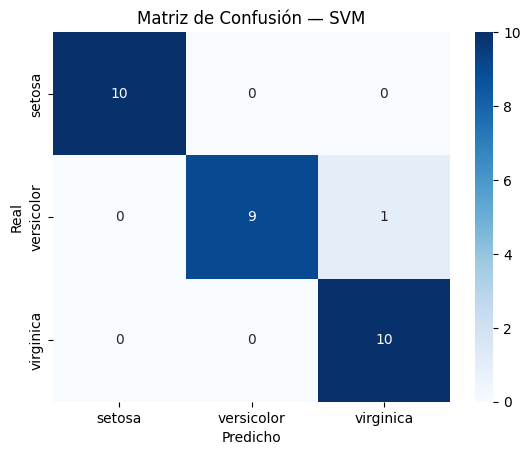

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = mejor_modelo.predict(X_test)
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred, target_names=iris.target_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión — {nombre_mejor}')
plt.show()

### 👩‍⚕️Análisis de los resultados

Aquí se analizan los resultados, tanto en términos de la eficacia de los modelos como del conocimiento que aportan.

## 💾 Persistencia del modelo seleccionado

Guardamos el mejor modelo para usarlo luego en una nueva notebook.

In [ ]:
mejor_modelo = grid_svm.best_estimator_
joblib.dump(mejor_modelo, 'modelo_svm_precio.joblib')
joblib.dump(X.columns.tolist(), 'columnas_entrenamiento.joblib')

Modelo guardado como modelo_iris_mejor.joblib


## 🛫 Cierre de la entrega: Reflexiones finales

En esta celda se hace un cierre de la etapa con observaciones sobre el resultado de los modelos, ventajas/desventajas, y posibles mejoras futuras.